In [26]:
from commonroad.common.file_reader import CommonRoadFileReader
from python_scripts.simulation import step_simulation
from python_scripts.visualizer import Visualizer
from python_scripts.utilities import load_results, merge_config, save_results
import yaml
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.gridspec as gridspec

def plot_raw_scenario(timestep, scenario, config):
    plt.cla()
    Visualizer().plot_unsimulated(scenario, config, timestep)
    plt.axis('scaled')
    plt.xlim(0,420)
    # plt.ylim(-45,-15)
    plt.ylim(-10,10)

def plot_result_scenario(time_step, ego_vehicle, scenarios, sensor_views):
    plt.cla()
    Visualizer().plot(scenario=scenarios[time_step],
                  sensor_view=sensor_views[time_step],
                  ego_vehicle=scenarios[time_step].obstacle_by_id(ego_vehicle.obstacle_id),
                  time_begin=time_step)
    plt.axis('scaled')
    plt.xlim(0,300)
    plt.ylim(-38, -15)

# Visualise raw scenario

In [ ]:
scenario_path = "scenarios/ZAM_trafficjam-1_1_T-1"


#======================================================#
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario, _ = CommonRoadFileReader(scenario_path + ".xml").open()

fig = plt.figure(figsize=(12, 2))
anim = animation.FuncAnimation(fig, 
                               plot_raw_scenario, 
                               fargs=[scenario, config], 
                               frames=range(config["simulation_duration"]), 
                               interval=200,
                               blit=False)
HTML(anim.to_html5_video())

# Simulate Single scenario

In [ ]:
scenario_path = "scenarios/highd_scenarios/ZAM_HighD-1_2_T-1"
results_folder = "results/"


#======================================================#
with open("scenarios/highd_config.yaml") as file:
    global_config = yaml.load(file, Loader=yaml.FullLoader)
with open(scenario_path + ".yaml") as file:
    scenario_config = yaml.load(file, Loader=yaml.FullLoader)
config = merge_config(global_config, scenario_config)

scenario1, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario2, _ = CommonRoadFileReader(scenario_path + ".xml").open()
scenario3, _ = CommonRoadFileReader(scenario_path + ".xml").open()

config['occlusion_params']['save_shadows'] = True

config['occlusion_params']['ideal_tracking_enabled'] = False
config['occlusion_params']['velocity_tracking_enabled'] = True
tracked_results = step_simulation(scenario1, config)

config['occlusion_params']['ideal_tracking_enabled'] = False
config['occlusion_params']['velocity_tracking_enabled'] = False
untracked_results = step_simulation(scenario2, config)

config['occlusion_params']['ideal_tracking_enabled'] = True
config['occlusion_params']['velocity_tracking_enabled'] = True
ideal_results = step_simulation(scenario3, config)

save_path = os.path.join(results_folder, str(scenario1.scenario_id))
save_results(save_path, ideal_results, tracked_results, untracked_results, scenario1, scenario_config)

# Visualise Results


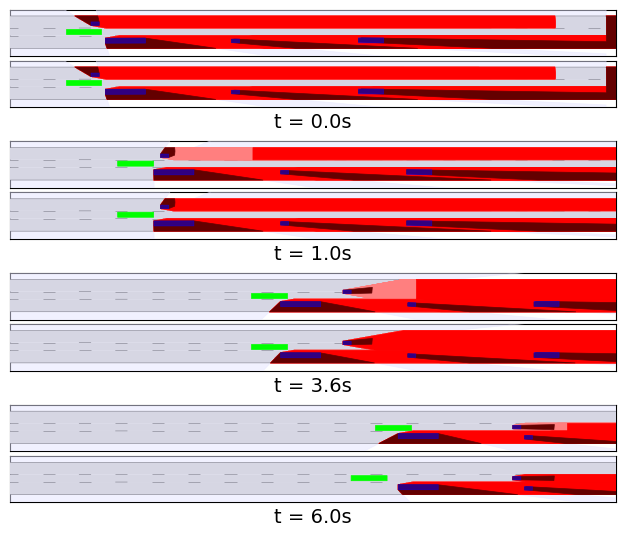

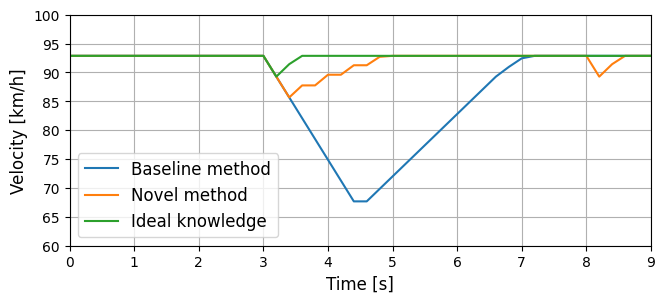

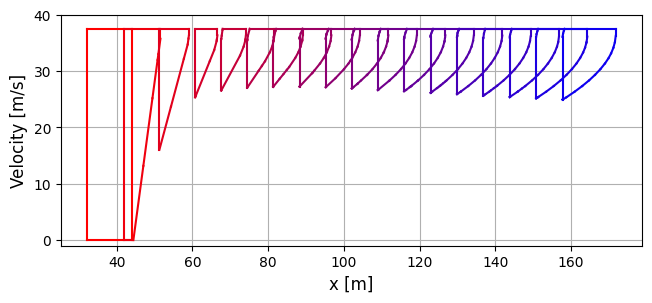

In [29]:
results_file = "results/ZAM_HighD-51_1_T-1"
#results_file = "results/highd_simulations_pickle_new/ZAM_HighD-26_10_T-1"
create_animations = False
plot_figures_at_timesteps = [0,5,18,30]
plot_velocity_profiles = True
plot_distance = False
plot_shadows = [0]
print_computational_times = False


#===========================================================================#
data = load_results(results_file)

if create_animations:
    # NOVEL METHOD
    ego_vehicle = data["novel_method"]["ego_vehicle"]
    scenarios = data["novel_method"]["scenarios"]
    views = data["novel_method"]["views"]
    simulation_length = data["simulation_length"]

    fig = plt.figure(figsize=(12, 2), dpi=150)
    anim = animation.FuncAnimation(fig,
                                plot_result_scenario, 
                                fargs=[ego_vehicle, scenarios, views], 
                                frames=simulation_length, 
                                interval=200, 
                                blit=False)
    HTML(anim.to_html5_video())

    # BASELINE METHOD
    ego_vehicle = data["baseline_method"]["ego_vehicle"]
    scenarios = data["baseline_method"]["scenarios"]
    views = data["baseline_method"]["views"]
    simulation_length = data["simulation_length"]

    fig = plt.figure(figsize=(12, 2), dpi=150)
    anim = animation.FuncAnimation(fig, 
                                plot_result_scenario, 
                                fargs=[ego_vehicle, scenarios, views], 
                                frames=simulation_length, 
                                interval=200, 
                                blit=False)
    HTML(anim.to_html5_video())

    # IDEAL METHOD
    ego_vehicle = data["ideal_method"]["ego_vehicle"]
    scenarios = data["ideal_method"]["scenarios"]
    views = data["baseline_method"]["views"]
    simulation_length = data["simulation_length"]

    fig = plt.figure(figsize=(12, 2), dpi=150)
    anim = animation.FuncAnimation(fig, 
                                plot_result_scenario, 
                                fargs=[ego_vehicle, scenarios, views], 
                                frames=simulation_length, 
                                interval=200, 
                                blit=False)
    HTML(anim.to_html5_video())

if plot_figures_at_timesteps:
    plt.subplots_adjust(hspace=0.35)
    outer = gridspec.GridSpec(len(plot_figures_at_timesteps), 1) 

    for i, t in enumerate(plot_figures_at_timesteps):
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[i], hspace = 0.1)

        ax = plt.subplot(gs[0])
        plot_result_scenario(t, data["novel_method"]["ego_vehicle"], data["novel_method"]["scenarios"], data["novel_method"]["views"])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(gs[1])
        plot_result_scenario(t, data["baseline_method"]["ego_vehicle"], data["baseline_method"]["scenarios"], data["baseline_method"]["views"])
        ax.set_xticks([])
        ax.get_yaxis().set_visible(False)

        ax.set_xlabel("".join(["t = ", str(round(t*0.2,2)), "s"]), fontsize=14)
    plt.gcf().set_size_inches(12, len(plot_figures_at_timesteps)*1.6)

    # fig, ax = plt.subplots(nrows = len(plot_figures_at_timesteps), ncols = 2, dpi=150)
    # for i, t in enumerate(plot_figures_at_timesteps):
    #     plt.sca(ax[i][0])
    #     plot_result_scenario(t, data["novel_method"]["ego_vehicle"], data["novel_method"]["scenarios"], data["novel_method"]["views"])
    #     ax[i][0].set_xlabel("".join(["t = ", str(t*0.2), "s"]))
    #     ax[i][0].set_xticks([])
    #     ax[i][0].set_yticks([])

    #     plt.sca(ax[i][1])
    #     plot_result_scenario(t, data["baseline_method"]["ego_vehicle"], data["baseline_method"]["scenarios"], data["baseline_method"]["views"])
    #     ax[i][1].set_xlabel("".join(["t = ", str(t*0.2), "s"]))
    #     ax[i][1].set_xticks([])
    #     ax[i][1].set_yticks([])
    # fig.suptitle("Evolution of the scenario for the novel method (left) and baseline (right)")
    # plt.subplots_adjust(wspace=0.02)
    # plt.gcf().set_size_inches(12, len(plot_figures_at_timesteps)*0.6+0.5)

if plot_velocity_profiles:
    ego_novel = data["novel_method"]["ego_vehicle"]
    ego_baseline = data["baseline_method"]["ego_vehicle"]
    ego_ideal = data["ideal_method"]["ego_vehicle"]
    ego_recorded = data["recorded_ego_speed"]

    plt.figure(figsize=(7.5, 3))
    labels = ['Baseline method','Novel method', 'Ideal knowledge', 'Recorded trajectory']
    for idx, vehicle in enumerate([ego_baseline, ego_novel, ego_ideal]):
        velocities = [round(vehicle.initial_state.velocity*3.6, 2)]
        time = [round(vehicle.initial_state.time_step/10, 2)]
        for state in vehicle.prediction.trajectory.state_list:
            velocities.append(round(state.velocity*3.6, 2))
            time.append(round(state.time_step/5, 2))
        plt.plot(time, velocities, label=labels[idx])
    #plt.plot(time, np.array(ego_recorded[::5])*3.6, label=labels[-1]) #forgot to downsample recorded vel
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Velocity [km/h]',fontsize=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.ylim(60, 100)
    plt.xlim(0,9)
    #plt.title("Velocity profiles for the different methods of occlusion tracking")

if plot_distance:
    ego_novel = data["novel_method"]["ego_vehicle"]
    ego_baseline = data["baseline_method"]["ego_vehicle"]
    ego_ideal = data["ideal_method"]["ego_vehicle"]
    scenario = data["scenario"]
    simulation_length = data["simulation_length"]

    with open("scenarios/highd_scenarios/" + os.path.basename(results_file) + ".yaml") as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

    dists_novel = find_RSS_distance(ego_novel, scenario, config)
    dists_baseline = find_RSS_distance(ego_baseline, scenario, config)
    dists_ideal = find_RSS_distance(ego_ideal, scenario, config)
    time = np.linspace(0.2, simulation_length/5, simulation_length-1) #assuming dt = 0.2

    plt.figure(figsize=(7.5,3))
    labels = ['Baseline method','Novel method', 'Ideal knowledge']

    plt.plot(time, dists_baseline, label=labels[0])
    plt.plot(time, dists_novel, label=labels[1])
    plt.plot(time, dists_ideal, label=labels[2])
    plt.legend()
    plt.grid()
    plt.ylim(0, 100)
    plt.xlim(0,9)

    plt.xlabel('Time [s]')
    plt.ylabel('Distance Headway [m]')

if plot_shadows:
    plotting_length = int(18)
    shadows_novel = data["novel_method"]["shadows"]
    try:
        shadows_novel[0]
    except:
        print("Shadows have not been saved for this scenario")
    else:
        for shadow in plot_shadows:
            Visualizer().plot_3D_shadows(shadows_novel[shadow],plotting_length,np.arange(0,plotting_length,1))

if print_computational_times:
    print("Update time novel method: ", data["novel_method"]["computational_time"]["update_step"])
    print("Prediction time novel method: ", data["novel_method"]["computational_time"]["prediction_step"])
    print("Update time baseline method: ", data["baseline_method"]["computational_time"]["update_step"])
    print("Prediction time baseline method: ", data["baseline_method"]["computational_time"]["prediction_step"])